# s06: EEG magic

In [149]:
from pathlib import Path
import scipy.io as sio
from scipy.stats import pearsonr, ttest_rel
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd

import numpy as np
import seaborn as sns

plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})

## Set path and load data fro you local machine
First we will detect where the current script is located on our harddrive. We will points VS code to the location of the file we want to load. The raw data is in MatLab format, luckerly scipy can handle this issue.

<div class="alert alert-danger">
Load data with relativ path (1 point).

</div>

In [150]:
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script, "files")
fname = 'tutorial1-01.mat'
data = sio.loadmat(Path.joinpath(dir_rawdata,fname))
data_mne = np.vstack((data['EEG'],data['labels']))

In [151]:
data['EEG']
data['labels']

array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [152]:
data['EEG'].shape

(7, 288349)

## Explore the loaded data
To understand the data we were handed please explore what the variable contains.

<div class="alert alert-danger">
Determine the shape of the EEG data (1 point).
Determine the names of the triggers in the data (1 point).

</div>

In [153]:
print('EEG dimensions:', data['EEG'].shape)
print('Label dimensions:', data['labels'].shape)
print(np.unique(data['labels']))

EEG dimensions: (7, 288349)
Label dimensions: (1, 288349)
[0 1 2 3 4 5 6 7 8 9]


## Set config vars for MNE
To process the data we have to hardcode a couple of information to pass to the MNE toolbox.
For now these are channel names and types of our data, as well as the sampling rate.


In [154]:
# convert raw numpy to mne
n_channels = data['EEG'].shape[0]+1
ch_types = ['eeg'] * n_channels
ch_types[-1] = 'stim'
ch_nms = ['Fz', 'Cz', 'Pz', 'CP1', 'CP3', 'C3', 'C4','status']
srate = 2048

info = mne.create_info(ch_names=ch_nms, sfreq=srate, ch_types=ch_types)


## Create MNE object
With the raw data loaded and the config variables defined, we can initiate the MNE object.

In [155]:
raw = mne.io.RawArray(data_mne, info);

Creating RawArray with float64 data, n_channels=8, n_times=288349
    Range : 0 ... 288348 =      0.000 ...   140.795 secs
Ready.


WOW, that was super easy (when you know the right functions XD).
Lets, already do some basic processing of the data.

In [156]:
raw.filter(0.5, 20);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 13517 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished


In [157]:
#store data for seminar
pd.DataFrame(data['EEG']).to_csv(r'./files/eeg_raw.csv', index=False)
pd.DataFrame(data['labels']).to_csv(r'./files/eeg_labels.csv', index=False)

## Prepare epoching
To better understand the data, we want to find events in the raw data and epoch around these.

In [ ]:
url_eeg_raw = 'https://raw.githubusercontent.com/BioPsychKiel/datascience_in_practice/main/tutorials/files/eeg_raw.csv'
url_eeg_labels = 'https://raw.githubusercontent.com/BioPsychKiel/datascience_in_practice/main/tutorials/files/eeg_labels.csv'

EEG = np.array(pd.read_csv(url_eeg_raw))
labels = np.array(pd.read_csv(url_eeg_labels))
labels = labels[0]

cards = [
    'Ace of spades',
    'Jack of clubs',
    'Queen of hearts',
    'King of diamonds',
    '10 of spaces',
    '3 of clubs',
    '10 of hearts',
    '3 of diamonds',
    'King of spades',
]

onsets = np.flatnonzero(labels)
print(onsets[:10])  # Print the first 10 onsets
print('Number of onsets:', len(onsets))


[ 7789  8790  9814 10838 11862 12886 13910 14934 15958 16982]
Number of onsets: 270


In [ ]:
classes = labels[onsets]
print('Card shown at each onset:', classes[:10])

Card shown at each onset: [3 6 7 9 1 8 5 2 4 9]


Now lets do the epoching

In [ ]:
nchannels = 7 # 7 EEG channels
sample_rate = 2048. # The sample rate of the EEG recording device was 2048Hz
nsamples = int(1.0 * sample_rate) # one second's worth of data samples
ntrials = len(onsets)

trials = np.zeros((ntrials, nchannels, nsamples))
for i, onset in enumerate(onsets):
    trials[i, :, :] = EEG[:, onset:onset + nsamples]
    
print(trials.shape)

(270, 7, 2048)


## Defining a function
Because we will probably plot our data a trazillion times, lets define a function to make the code look cleaner.

In [ ]:
def plot_eeg(EEG, vspace=100, color='k'):
    '''
    Plot the EEG data, stacking the channels horizontally on top of each other.

    Parameters
    ----------
    EEG : array (channels x samples)
        The EEG data
    vspace : float (default 100)
        Amount of vertical space to put between the channels
    color : string (default 'k')
        Color to draw the EEG in
    '''
    
    bases = vspace * np.arange(7) # vspace * 0, vspace * 1, vspace * 2, ..., vspace * 6
    
    # To add the bases (a vector of length 7) to the EEG (a 2-D Matrix), we don't use
    # loops, but rely on a NumPy feature called broadcasting:
    # http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    EEG = EEG.T + bases
    
    # Calculate a timeline in seconds, knowing that the sample rate of the EEG recorder was 2048 Hz.
    samplerate = 2048.
    time = np.arange(EEG.shape[0]) / samplerate
    
        # Plot EEG versus time
    plt.plot(time, EEG, color=color)

    # Add gridlines to the plot
    plt.grid()
    
    # Label the axes
    plt.xlabel('Time (s)')
    plt.ylabel(r'Channels Amplitude [$\mu$V]')
    
    # The y-ticks are set to the locations of the electrodes. The international 10-20 system defines
    # default names for them.
    plt.gca().yaxis.set_ticks(bases)
    plt.gca().yaxis.set_ticklabels(['Fz', 'Cz', 'Pz', 'CP1', 'CP3', 'C3', 'C4'])
    
    # Put a nice title on top of the plot
    plt.title('EEG data')

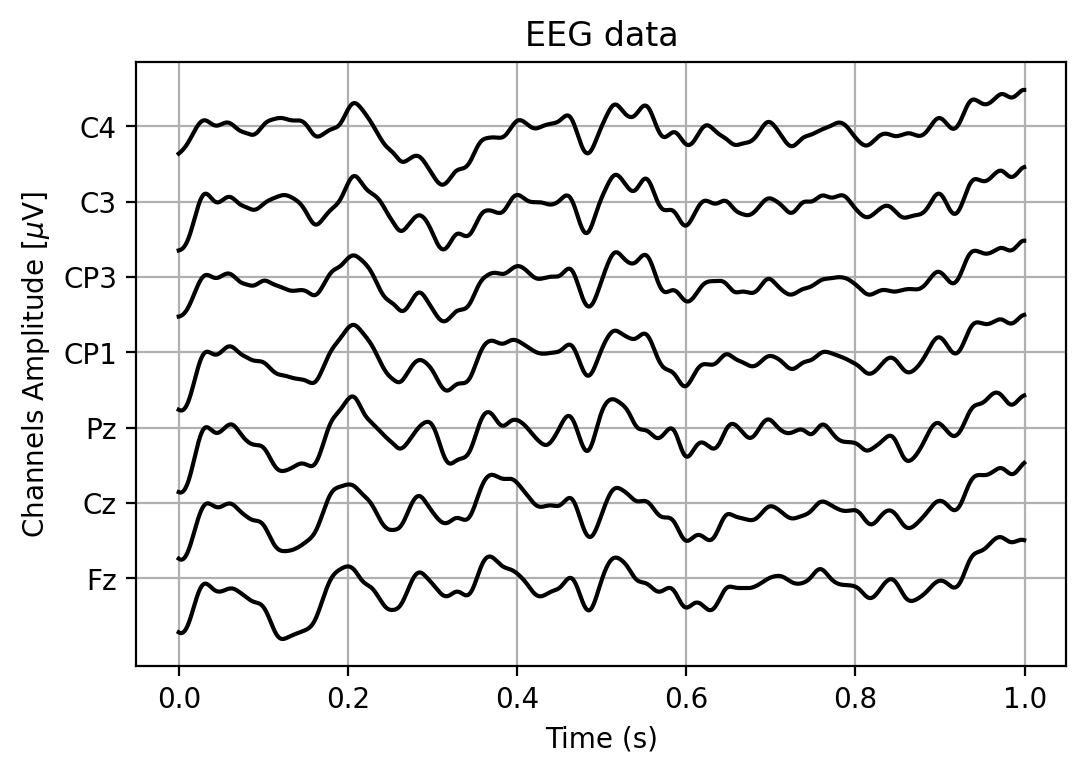

In [ ]:
# run the function with our eeg data from one trial
idx_trial = 0
plt.figure(figsize=(6,4))
plot_eeg(trials[idx_trial, :, :], vspace=30)

## More plotting
"Why do you always plot your data?" <br>
"Because I can" - *Immanuel Kant*

(0.0, 0.4)

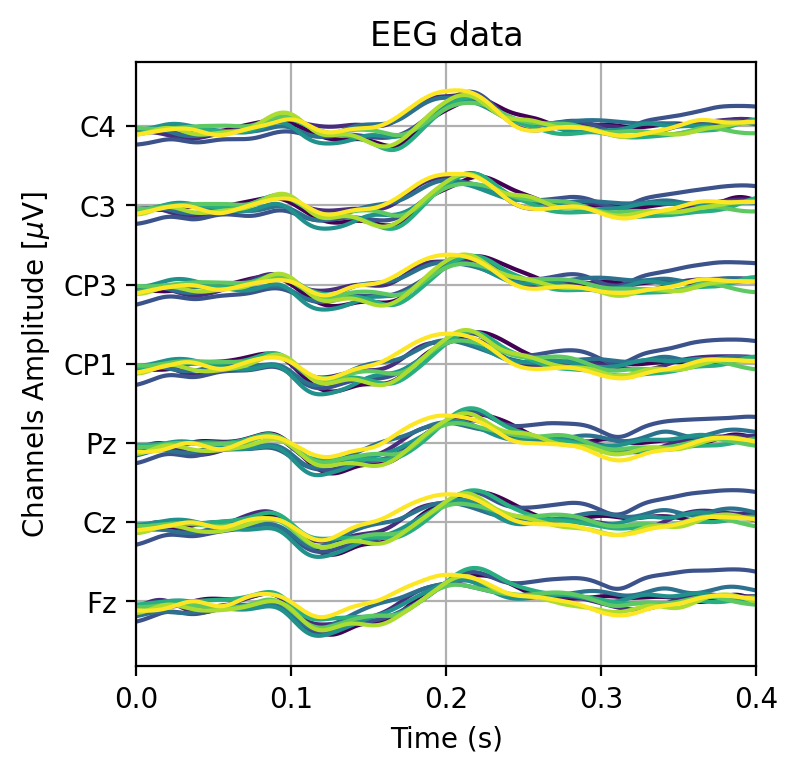

In [ ]:
# Lets give each response a different color
cfg_colors_eeg_plot_trials = plt.cm.viridis(np.linspace(0,1,EEG.shape[0]+2))

plt.figure(figsize=(4,4))

# Plot the mean EEG response to each card, such an average is called an ERP in the literature
for i in range(len(cards)):
    # Use logical indexing to get the right trial indices
    erp = np.mean(trials[classes == i+1, :, :], axis=0)
    plot_eeg(erp, vspace=30, color=cfg_colors_eeg_plot_trials[i])
plt.xlim(0,0.4)

## Find features
For the classification we want to extract the P300 amplitude. Easy!

In [ ]:
from_index = int(0.25 * sample_rate)
to_index = int(0.4 * sample_rate)
p300_amplitudes = np.mean(np.mean(trials[:, :, from_index:to_index], axis=1), axis=1)
p300_amplitudes -= min(p300_amplitudes) # Make them all positive

Text(0.5, 1.0, 'Card : Queen of hearts')

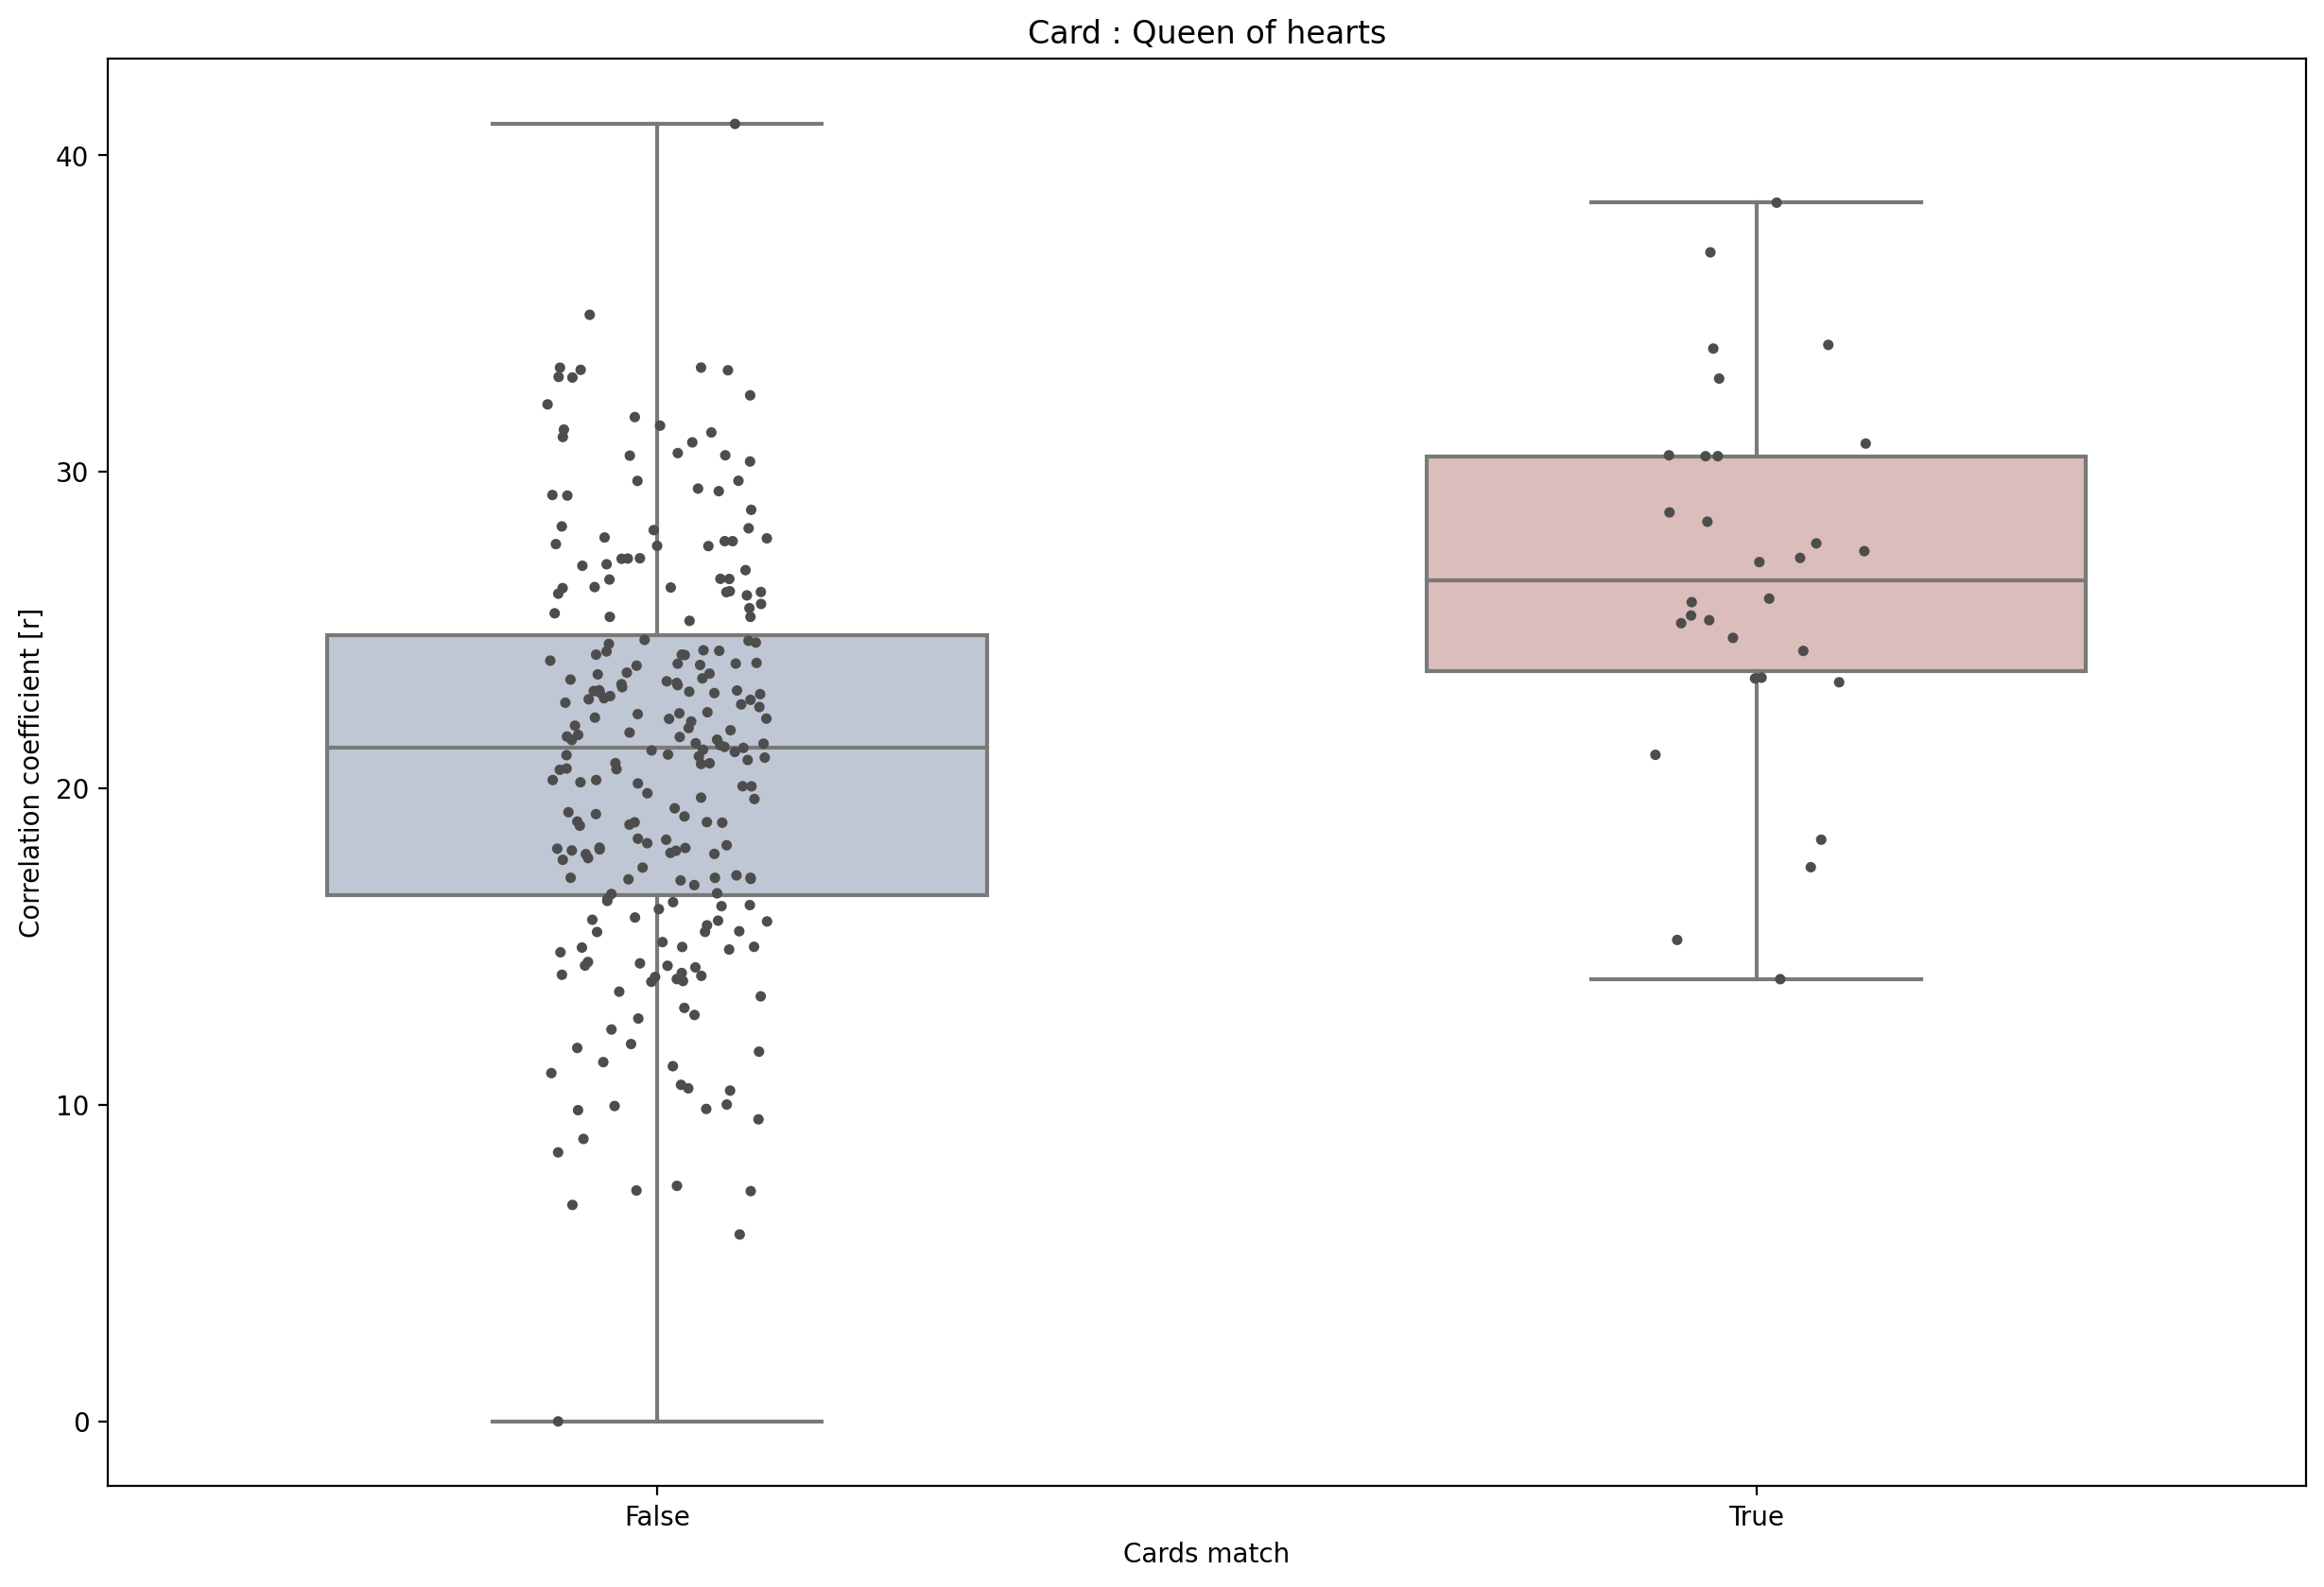

In [ ]:
card_oi = 3
pearsonr(classes == card_oi, p300_amplitudes)
sns.boxplot(x=classes == card_oi,y=p300_amplitudes,whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(x=classes == card_oi,y=p300_amplitudes,size=4, color=".3", linewidth=0,dodge=True)
plt.ylabel('Correlation coefficient [r]')
plt.xlabel('Cards match')
plt.title(f'Card : {cards[card_oi-1]}')

Was your card the Queen of hearts?


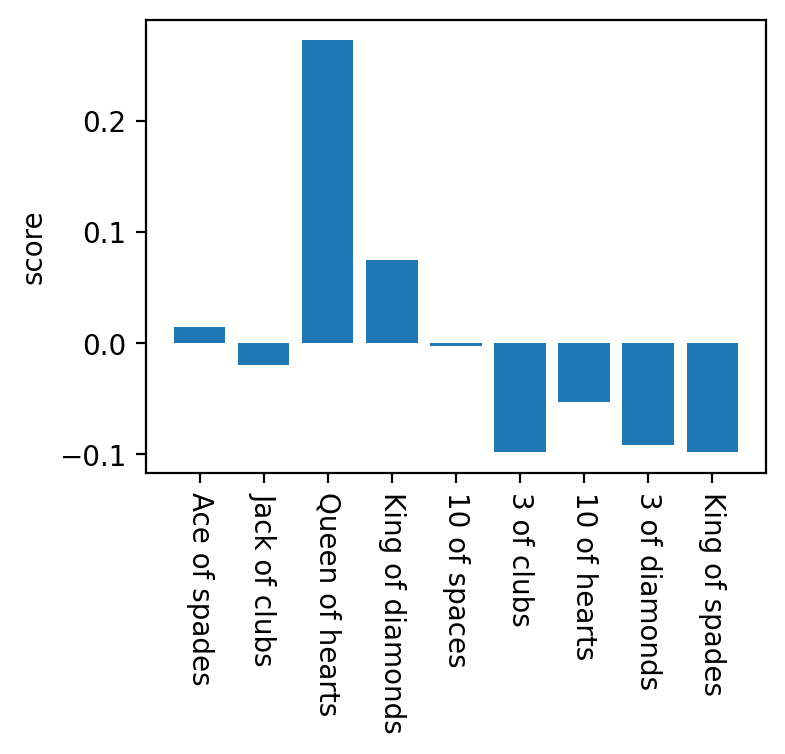

In [ ]:
nclasses = len(cards)
scores = [pearsonr(classes == i+1, p300_amplitudes)[0] for i in range(nclasses)]

# Plot the scores
plt.figure(figsize=(4,3))
plt.bar(np.arange(nclasses)+1, scores, align='center')
plt.xticks(np.arange(nclasses)+1, cards, rotation=-90)
plt.ylabel('score')

# Pick the card with the highest score
winning_card = np.argmax(scores)
print('Was your card the %s?' % cards[winning_card])